<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/master/02-Machine-Learning/notebooks/07-Perceptron-SOL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptrón

En esta notebook implementaremos el perceptrón y el perceptrón con kernel. Lo compararemos con los otros modelos lineales vistos hasta ahora: SVM y OLS.

Una versión más sofisticada del [perceptrón](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) se encuentra implementado en scikit-learn. Sin embargo, lo implementaremos al tratarse de un algoritmo sencillo.

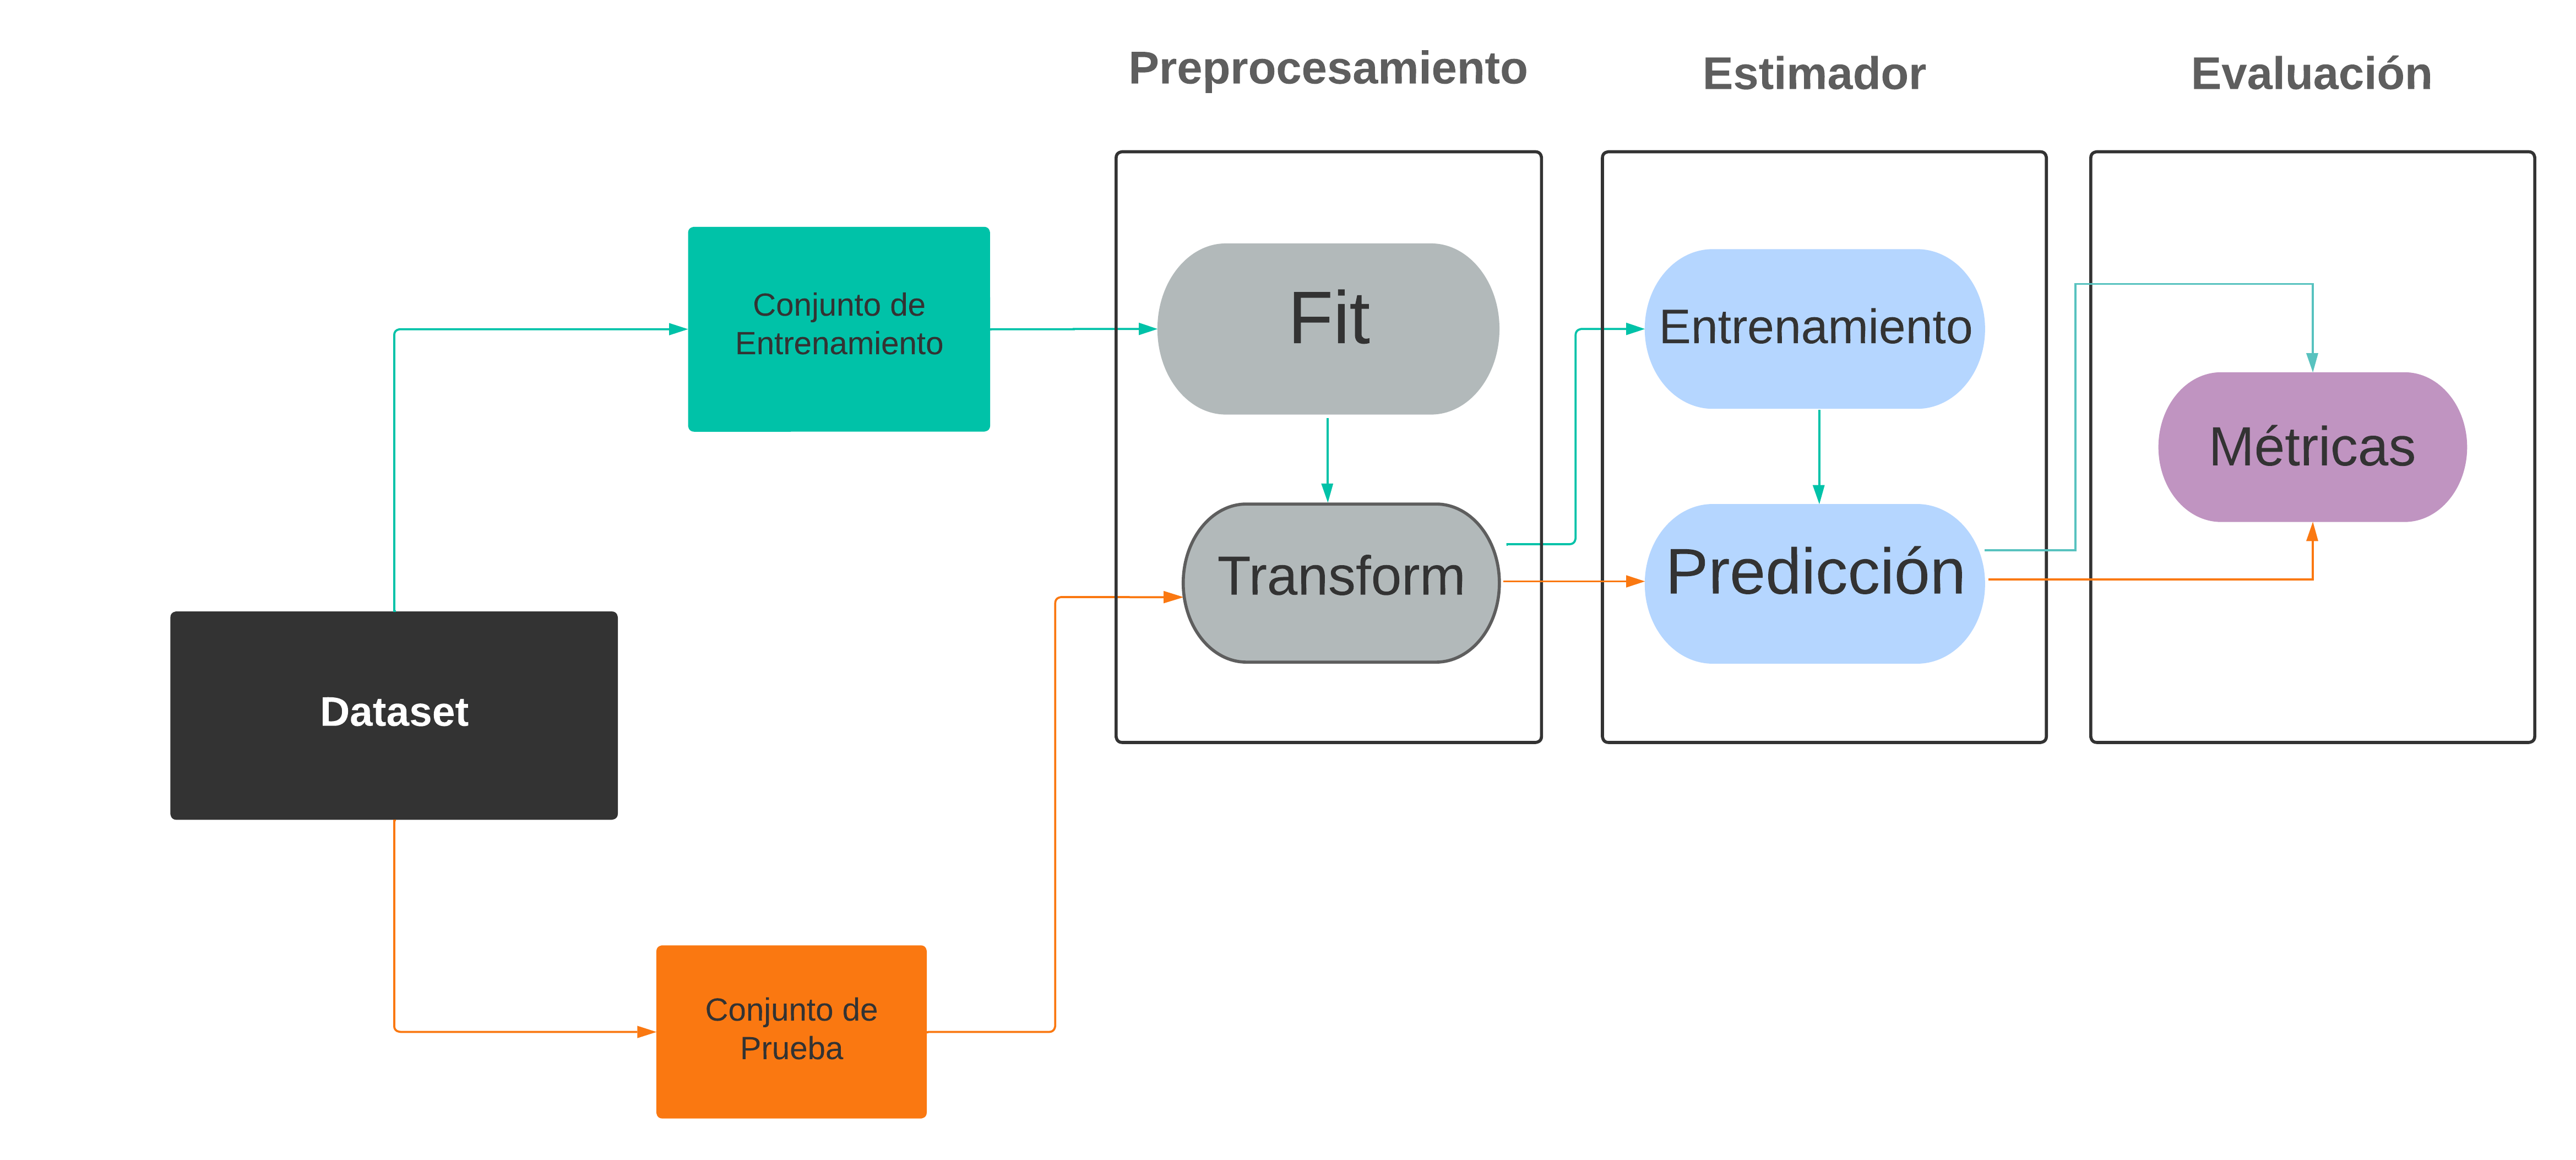

___

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
#@title Función para graficar

def grafica(x_train,y_train,x_test,y_test):
    '''
    Grafica los datos de entrenamiento y prueba
    Entrada: Datos
    Salida: scatter plot con datos diferenciados
    '''
    fig,ax = plt.subplots(figsize=(6,5))
    clases = np.unique(y_train).astype(int)
    # --- Datos de entrenamiento ---
    ax.scatter(x_train[:,0][y_train==clases[0]], x_train[:,1][y_train==clases[0]],
               facecolor='blue', 
               marker='o', 
               edgecolor='royalblue',
               s=60,
               label='neg train')
    """Datos positivos de entrenamiento"""
    ax.scatter(x_train[:,0][y_train==clases[1]], x_train[:,1][y_train==clases[1]],
               facecolor='orangered', 
               marker='o', 
               edgecolor='orangered',
               s=60,
               label='pos train')
    # --- Datos de prueba ---
    ax.scatter(x_test[:,0][y_test==clases[0]], x_test[:,1][y_test==clases[0]],
               facecolor='royalblue', 
               marker='x', 
               s=45,
               label='neg test')
    ax.scatter(x_test[:,0][y_test==clases[1]], x_test[:,1][y_test==clases[1]],
               facecolor='r', 
               marker='x', 
               s=45,
               label='pos test')
    # --- Formatear el área de 'legend'
    legend = plt.legend(loc='upper center',
                    bbox_to_anchor=(0.5, 1.075),
                    ncol=4,
                    fancybox=True,
                    shadow=False)

    return fig,ax

Generamos datos no linealmente separables

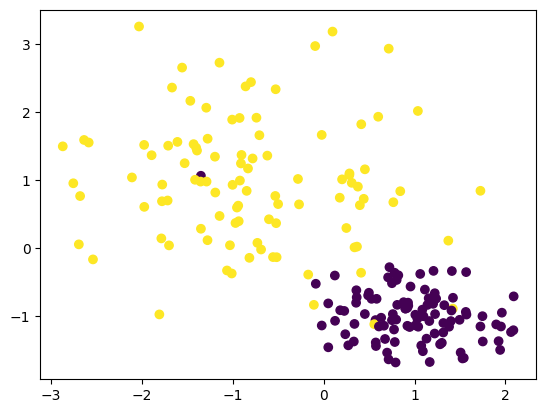

In [7]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

X, y = make_classification(n_samples=200,
                           n_features=2,
                           n_informative=2,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           n_clusters_per_class=1,
                           random_state=37)

plt.figure()
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

## Modelo Perceptron:

Realizaremos nuestra propia implementación. Scikit-learn tiene una implementación de este modelo https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html.

In [8]:
from sklearn.metrics import accuracy_score, recall_score, precision_score

class SPerceptron(object):
    '''
    Clasificador Perceptron
    '''

    def __init__(self, epocas=1, eta=1.):
        self.epocas = epocas    
        self.eta = eta  #tasa de aprendizaje

    def fit(self, X, y, show_error=False):
        '''
        Funcion de aprendizaje
        Entrada: datos de entrenamiento X,y en coordenadas homogeneas
        Calcula: W, los pesos del modelo, y el Error de aprendizaje
        '''         
        n_samples, n_features = X.shape                 
        self.W = np.zeros(n_features, dtype=np.float64) # inicializamos el vector de pesos
        self.W_history = []
        errors = []
        # --- cambiamos las etiquetas 0 por -1 ---
        y_new = y.copy()
        y_new[y_new==0] = -1
        # --- iteramos en las épocas ---
        for e in range(self.epocas):
            total_error = 0
            for i in range(n_samples):
                if self.pred(X[i])*y_new[i] <= 0:
                    self.W_history.append(self.W.copy())
                    self.W += y_new[i] * self.eta * X[i]
                    total_error += self.pred(X[i])*y_new[i]
            errors.append(total_error)
        self.W_history.append(self.W.copy())
        if show_error:
            xticks=np.arange(self.epocas)
            plt.xticks(xticks,[str(x) for x in xticks])
            plt.plot(errors,label='Perceptron')
            plt.xlabel('Epoca')
            plt.ylabel('Error total')
            plt.legend()
        
    def pred(self, X):
        '''
        Funcion que determina el signo de la predicción
        Entrada: arreglo numpy de datos X
        Salida:  arreglo numpy con valores +1 o -1 
        '''         
        return np.sign(X@self.W).astype(int)

    def predict(self, X):
        '''
        Funcion que determina el signo de la predicción
        Entrada: arreglo numpy de datos X
        Salida:  arreglo numpy con valores +1 o -1 
        '''   
        y_pred = self.pred(X)
        y_pred[y_pred == -1] = 0
        return y_pred
    
    def metricas(self, X, y):
        '''
        Funcion de evaluacion del rendimiento
        Entrada: arreglos numpy con datos de prueba y prediccion
        Salida: exactitud, precision y recall          
        ''' 
        y_pred = self.predict(X)
        accuracy = accuracy_score(y,y_pred)
        precision = precision_score(y,y_pred)
        recall = recall_score(y,y_pred)
        return {'accuracy':accuracy, 
                'precision':precision, 
                'recall':recall}
    
    def f(self,x,c=0):
        '''
        dados x y w, regresa 'y' tal que '(x,y)' esta sobre la linea
        w.x + b = c
        w es el vector ortogonal a la recta
        '''
        v = (-self.W[1]*x - self.W[0] + c) / self.W[2]
        return v

    
    def plot_FD(self,ax):
        '''
        Calcula los puntos de la linea recta 
        que representa la frontera de decision de un perceptron lineal
        Entrada: datos de las dos clases X1 y X2
        Salida: dos puntos extremos de la frontera de decision
        '''
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        a0 = xmin
        a1 = self.f(a0)
        b0 = xmax 
        b1 = self.f(b0) 
        x=[a0,b0]
        y=[a1,b1]
        ax.plot(x, y, "k", label='Perceptron')
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(ymin,ymax)
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)
        legend = plt.legend(loc='upper center',
                    bbox_to_anchor=(0.5, 1.15),
                    ncol=4,
                    fancybox=True,
                    shadow=False)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_alpha(1)
        return ax


## Prueba del Perceptrón

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=19)

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)
X_test = features.transform(x_test)

{'accuracy': 0.96875, 'precision': 0.9868421052631579, 'recall': 0.9493670886075949}


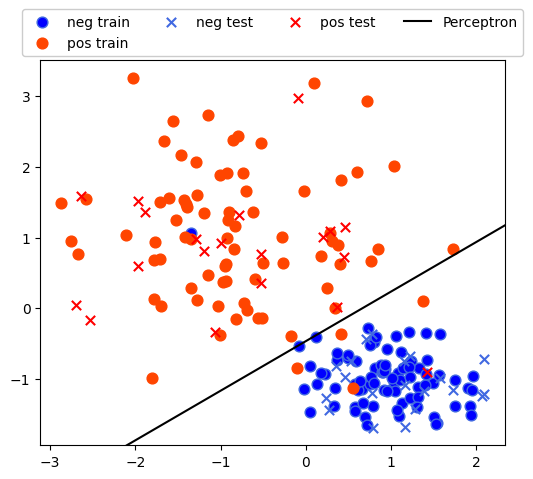

In [10]:
clf = SPerceptron()
# entrenamiento:
clf.fit(X_train, y_train)
# métricas de rendimiento:
print(clf.metricas(X_train,y_train))
# graficamos
fig,ax = grafica(x_train,y_train,x_test,y_test)
clf.plot_FD(ax)
fig.show()

Implementación del perceptron con kernel

In [11]:
#@title Perceptron con Kernel
class PerceptronKernel():
    """
    Perceptron con Kernel básico
    """
    def __init__(self, kernel='lk',**params):
        self.epocas=1
        if kernel == 'lk':
            self.__kernel=self.__lk
            self.clave = 'K-Lineal'
        elif kernel == 'gk':
            self.__kernel=self.__gk
            self.clave = 'K-Gauss'
        else:
            self.__kernel=self.__pk
            self.clave = 'K-Poli'
        if params:
            for p in params.keys():
                if p=='epocas':
                    self.epocas = params[p]
                    continue
                if p=='gamma':
                    self.gamma=params[p]

    def __lk(self,Xi,Xj):
        return Xi@Xj
    
    def __pk(self,Xi,Xj):
        return (1 + Xi@Xj)**self.gamma

    def __gk(self,Xi, Xj):
        return np.exp(-self.gamma*np.linalg.norm(Xi-Xj)**2)

    @property    
    def kernel(self):
        return self.__kernel
    
    @kernel.setter
    def kernel(self,*args):
        try:
            l=args[0]
            ok=True
            if isinstance(l,str):
                kernel=l
            else:
                kernel=l[0]
                try:
                    parametro=l[1]
                except IndexError:
                    print("ERROR: Debes pasar también un parámetro-> gamma > 0")
                    ok=False
        except IndexError:
            print("ERROR: Debes pasar al menos un argumento con la etiqueta del kernel: {lk,gk,pk}")
            ok=False
        if ok:
            if kernel == 'lk':
                self.__kernel=self.__lk
                self.clave = 'K-Lineal'          #para la leyenda de la imagen
            elif kernel == 'gk':
                self.gamma = parametro       #gamma del kernel gaussiano
                self.__kernel=self.__gk
                self.clave = 'K-Gauss'
            else:
                self.gamma = parametro       #gamma del kernel gaussiano
                self.__kernel=self.__pk
                self.clave = 'K-Poli' 
        return

    def fit(self, X, y):
        """
        Funcion de aprendizaje
        In: X, matriz de instancias de aprendizaje
            y, matriz de clases
        Out: alpha vector de pesos de instancias de aprendizaje
        """         
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples, dtype=np.float64)
        
        clases = np.unique(y).astype(int)
        if clases[0]==0:
            y_temp=y[:]
            y_temp[y==0]=-1
            self.__y=y_temp[:]
            y_temp=[]
        else:
            self.__y=y[:]

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        # Entrenamiento
        for epoca in range(self.epocas):
            for i in range(n_samples):
                if self.__y[i]*np.sign(np.sum(K[i,:] * self.alpha * self.__y))<=0:
                    self.alpha[i] += 1.0

        # Support vectors
        sv = self.alpha > 1e-5
        ind = np.arange(len(self.alpha))[sv]
        self.alpha = self.alpha[sv]
        self.sv = X[sv]
        self.sv_y = self.__y[sv]
        print("{0} vectores de soporte de {1} puntos".format(len(self.alpha),n_samples))

    def decision_function(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.alpha, self.sv_y, self.sv):
                s += a * sv_y * self.__kernel(X[i], sv)
            y_predict[i] = s
        return y_predict

    def predict(self, X):
        return np.sign(self.decision_function(X))
    
    
    def metricas(self, X, y):
        '''
        Funcion de evaluacion del rendimiento
        Entrada: arreglos numpy con datos de prueba y prediccion
        Salida: exactitud, precision y recall          
        ''' 
        y_pred = self.predict(X)
        y_pred[y_pred==-1] = 0
        accuracy = accuracy_score(y,y_pred)
        precision = precision_score(y,y_pred)
        recall = recall_score(y,y_pred)
        return {'accuracy':accuracy, 
                'precision':precision, 
                'recall':recall}

# Comparación de los métodos lineales

En este ejercicio vamos a comparar la clasificación y la frontera de decisión del clasificador de la sesión anterior (discriminante lineal OLS) con el SVM con kernel lineal.

Para esto, vamos a usar ambos clasificadores en el mismo conjunto de datos. Después, compararemos la frontera de decisión.

In [4]:
url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/clasificador_lineal.py"
!wget --no-cache --backups=1 {url}

--2023-04-29 18:18:46--  https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/02-Machine-Learning/data/clasificador_lineal.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 840 [text/plain]
Failed to rename clasificador_lineal.py to clasificador_lineal.py.1: (2) No such file or directory
Saving to: ‘clasificador_lineal.py’

clasificador_lineal 100%[===================>]     840  --.-KB/s    in 0s      

2023-04-29 18:18:46 (28.7 MB/s) - ‘clasificador_lineal.py’ saved [840/840]



In [12]:
from clasificador_lineal import LeastSquaresClassifier

Definimos el conjunto de datos, usaremos un dataset de scikit-learn:

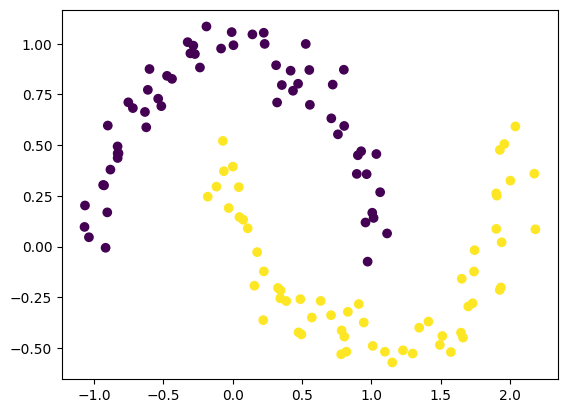

In [13]:
from sklearn.datasets import make_moons

x_train, y_train = make_moons(n_samples = 120, random_state=89, noise=0.1,)
# x_train, y_train = make_blobs(n_samples = 120, centers=2, random_state=89,noise=0.1)

#--- Lo graficamos para verlo ---
plt.figure()
plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
plt.show()

Ahora, comparemos los clasificadores lineales OLS, SVM y Perceptrón con el conjunto de datos anterior. 

Para visualizar la frontera de decisión y las regiones de decisión, definimos la siguiente malla que pasaremos por cada clasificador para obtener las etiquetas y colorear la malla.

In [25]:
# Mínimos y máximos de las coordenadas en x y y de los puntos
xmin, ymin = np.min(x_train,axis=0)
xmax, ymax = np.max(x_train,axis=0)

n = 100

x1_grid, x2_grid = np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n))
x_grid = np.array([x1_grid, x2_grid]).reshape(2, -1).T
x_grid.shape

(10000, 2)

Realiza la clasificación usando el clasificador OLS y grafica la frontera de decisión. Recuerda que OLS requiere que las features estén en coordenadas homogeneas, por lo cual usamos `PolinomialFeatures` con grado 1.

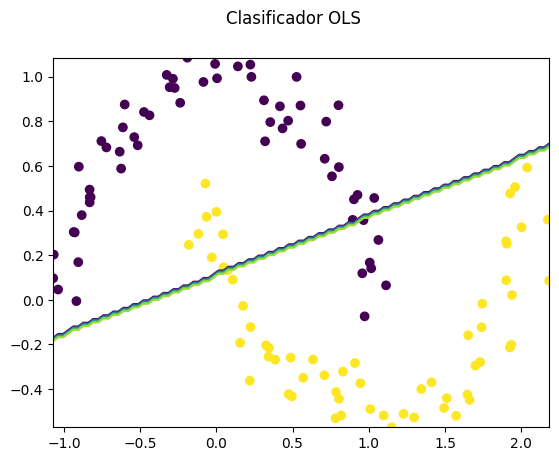

In [26]:
from sklearn.preprocessing import PolynomialFeatures

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)

modelo = LeastSquaresClassifier()   # Creamos la instancia del clasificador
modelo.fit(X_train,y_train)         # Entrenamos el módelo en el conjunto de entrenamiento

# --- generamos las predicciones para la malla
X_grid = features.transform(x_grid) 
y_grid_ols = modelo.clasifica(X_grid)

plt.figure()
plt.suptitle("Clasificador OLS")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_grid, x2_grid, y_grid_ols.reshape(100, 100))
plt.show()

Ahora, usemos SVM lineal. Realiza la clasificación en el mismo dataset, usando SVM con kernel lineal y grafica la frontera de decisión.
Puedes usar el código para clasificar y graficar que usamos anteriormente

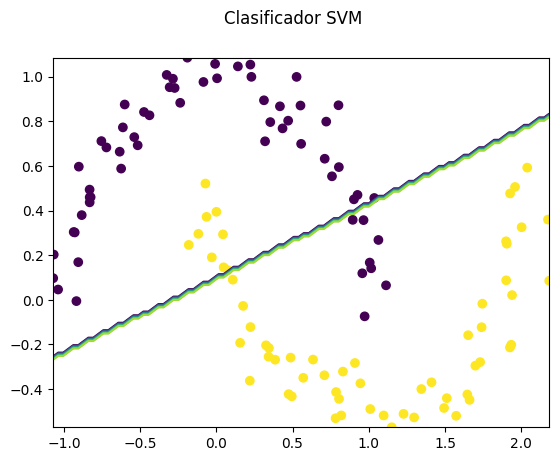

In [27]:
from sklearn.svm import SVC

# Entrenamos el módelo en el conjunto de entrenamiento
lin_svm = SVC(kernel='linear')
lin_svm.fit(x_train, y_train)

# --- generamos las predicciones para la malla
y_grid_svm = lin_svm.predict(x_grid)

plt.figure()
plt.suptitle("Clasificador SVM")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_grid (la malla de fondo para ver las regiones) ------------
plt.contour(x1_grid, x2_grid, y_grid_svm.reshape(100, 100))
plt.show()


Probemos con el perceptron

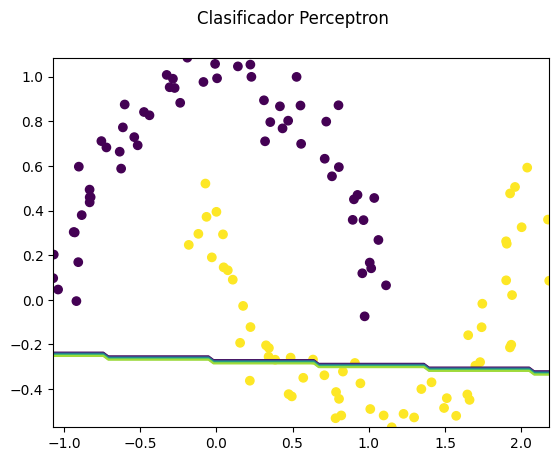

In [28]:
from sklearn.preprocessing import PolynomialFeatures

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)

# Entrenamos el módelo en el conjunto de entrenamiento
modelo = SPerceptron()   
modelo.fit(X_train,y_train)        

# --- generamos las predicciones para la malla
X_grid = features.transform(x_grid) 
y_grid_perc = modelo.predict(X_grid)

plt.figure()
plt.suptitle("Clasificador Perceptron")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_grid (la malla de fondo para ver las regiones) ------------
plt.contour(x1_grid, x2_grid, y_grid_perc.reshape(100, 100))
#-----Formato de la gráfica------------------------
plt.show()

Usemos el perceptron de scikit learn. Este estimador no usa el kernel.

0.8083333333333333


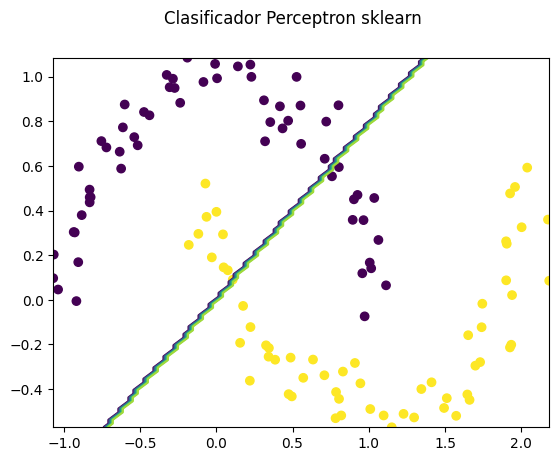

In [30]:
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import PolynomialFeatures

# Entrenamos el módelo en el conjunto de entrenamiento
modelo = Perceptron(penalty='l2',alpha=0.5,
                    early_stopping=True,
                    eta0=0.2)   
modelo.fit(x_train,y_train)     

# Evaluamos en el conjunto de entrenamiento
print(modelo.score(x_train,y_train))

# --- generamos las predicciones para la malla
y_grid_perc_sk = modelo.predict(x_grid)

plt.figure()
plt.suptitle("Clasificador Perceptron sklearn")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_grid (la malla de fondo para ver las regiones) ------------
plt.contour(x1_grid, x2_grid, y_grid_perc_sk.reshape(100, 100))
#-----Formato de la gráfica------------------------
plt.show()


Graficamos todas las fronteras de decision juntas

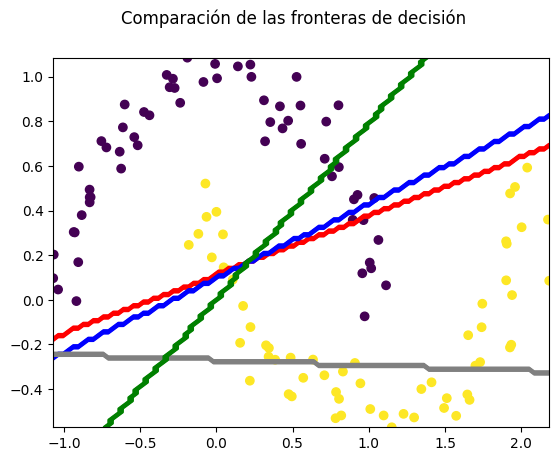

In [31]:
plt.figure()
plt.suptitle("Comparación de las fronteras de decisión")
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar las X_grid (la malla de fondo para ver las regiones) ------------
plt.contour(x1_grid, x2_grid, y_grid_ols.reshape(100, 100),colors='red')
plt.contour(x1_grid, x2_grid, y_grid_svm.reshape(100, 100),colors='blue')
plt.contour(x1_grid, x2_grid, y_grid_perc.reshape(100, 100),colors='gray')
plt.contour(x1_grid, x2_grid, y_grid_perc_sk.reshape(100, 100),colors='green')
plt.show()

Probemos el perceptron con kernel

22 vectores de soporte de 120 puntos


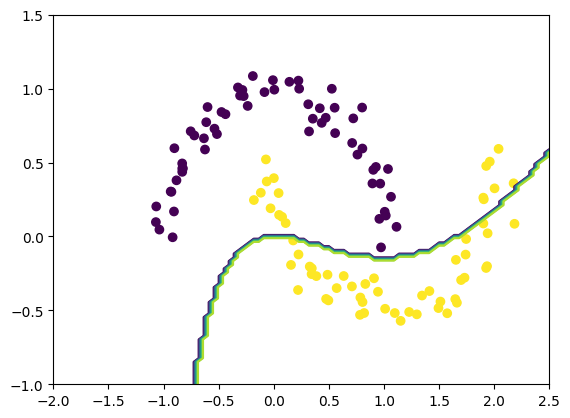

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

features = PolynomialFeatures(1)
X_train = features.fit_transform(x_train)

# Evaluamos en el conjunto de entrenamiento
modelo = PerceptronKernel(kernel='pk',gamma=3) # Kernel polinomial
# modelo = PerceptronKernel(kernel='gk',gamma=1) # Kernel RBF   
modelo.fit(X_train,y_train)        

# --- generamos las predicciones para la malla
X_grid = features.transform(x_grid) 
y_grid_perc_k = modelo.predict(X_grid)

plt.figure()
#-----Dibujar los datos---------------------------------
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
#-----Dibujar X_grid (la malla de fondo para ver las regiones) ------------
plt.contour(x1_grid, x2_grid, y_grid_perc_k.reshape(100, 100))
#-----Formato de la gráfica------------------------
plt.show()

#⭕ Práctica 1

Considera los siguientes 3 datasets. 


1.   Entrena un clasificador lineal (SVM lineal, OLS, Perceptron), grafica la frontera de decisión junto con el conjunto de entrenamiento. Reporta la matriz de confusión, accuracy y recall.
2.   Entrenar un clasificador lineal con kernel (SVM) para lograr el mejor posible accuracy. Puedes usar gridsearch. Grafica la frontera de decisión junto con el conjunto de entrenamiento.



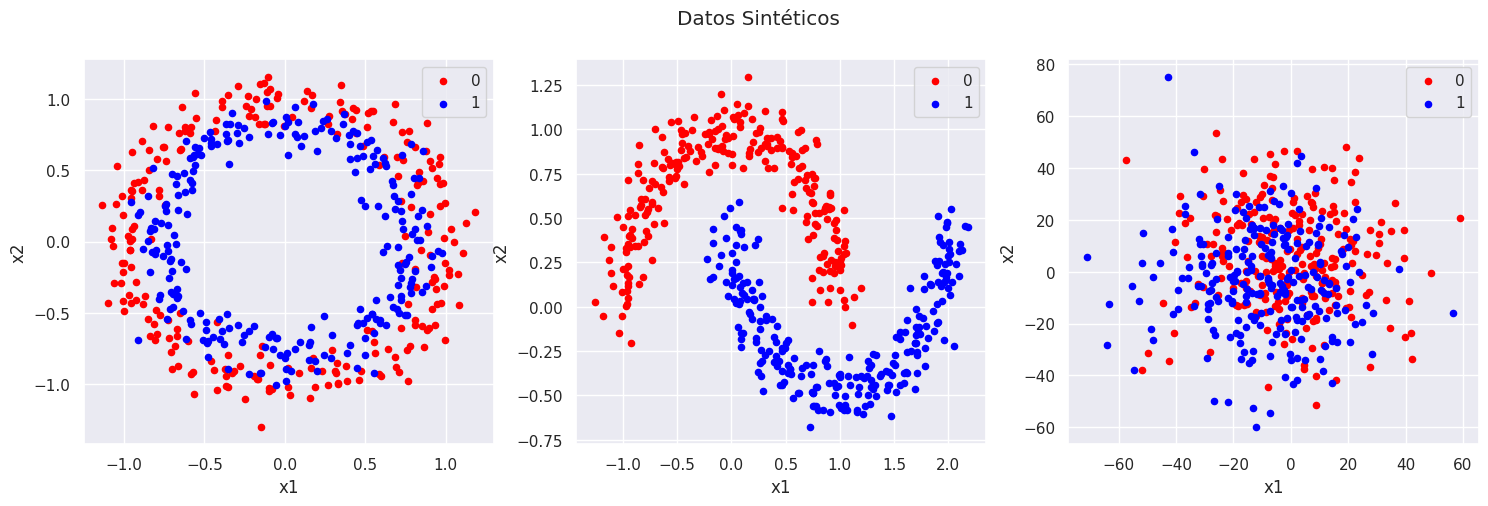

In [ ]:
from sklearn.datasets import make_blobs, make_circles, make_moons
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set();

exp_size = 500

# --- Los datasets ---
X_circ, y_circ = make_circles(n_samples=exp_size, noise=0.1,
                              random_state=1)
X_moon, y_moon = make_moons(n_samples=exp_size, noise=0.1,
                            random_state=1)
X_blob, y_blob = make_blobs(n_samples=exp_size, centers=2, cluster_std= 20,
                            n_features=2,random_state=1)

# scatter plot, dots colored by class value
df_circ = pd.DataFrame(dict(x1 = X_circ[:,0], x2=X_circ[:,1], label=y_circ))
df_moon = pd.DataFrame(dict(x1 = X_moon[:,0], x2=X_moon[:,1], label=y_moon))
colors_bin = {0:'red', 1:'blue'}

df_blob = pd.DataFrame(dict(x1 = X_blob[:,0], x2=X_blob[:,1], label=y_blob))
colors_mult = {0:'red', 1:'blue', 2:'green', 3:'purple'}

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
fig.suptitle('Datos Sintéticos')

grouped = df_circ.groupby('label')
for key, group in grouped:
    group.plot(ax=ax1, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_moon.groupby('label')
for key, group in grouped:
    group.plot(ax=ax2, kind='scatter', x='x1', y='x2', label=key, color=colors_bin[key])

grouped = df_blob.groupby('label')
for key, group in grouped:
    group.plot(ax=ax3, kind='scatter', x='x1', y='x2', label=key, color=colors_mult[key])

Un clasificador lineal, usamos OLS

Accuracy: 0.508
Precision: 0.508
Recall: 0.508


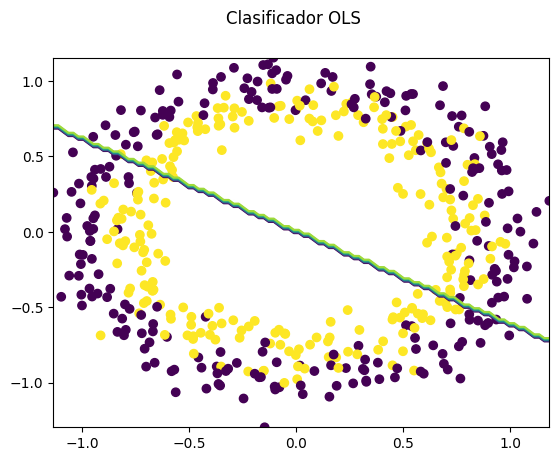

In [38]:
from clasificador_lineal import LeastSquaresClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, recall_score, precision_score

x_circ, y_circ = make_circles(n_samples=500, noise=0.1,
                              random_state=1)

# Mínimos y máximos de las coordenadas en x y y de los puntos
xmin, ymin = np.min(x_circ,axis=0)
xmax, ymax = np.max(x_circ,axis=0)

n = 100

x1_grid, x2_grid = np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n))
x_grid = np.array([x1_grid, x2_grid]).reshape(2, -1).T

features = PolynomialFeatures(1)
X_circ = features.fit_transform(x_circ)

modelo = LeastSquaresClassifier()   # Creamos la instancia del clasificador
modelo.fit(X_circ,y_circ)         # Entrenamos el módelo en el conjunto de entrenamiento

# --- métricas de rendimiento en el conjunto de entrenamiento ---
y_pred_circ = modelo.clasifica(X_circ)
print(f"Accuracy: {accuracy_score(y_circ,y_pred_circ)}")
print(f"Precision: {precision_score(y_circ,y_pred_circ)}")
print(f"Recall: {recall_score(y_circ,y_pred_circ)}")

# --- generamos las predicciones para la malla
X_grid = features.transform(x_grid) 
y_grid_ols = modelo.clasifica(X_grid)

plt.figure()
plt.suptitle("Clasificador OLS")
#-----Dibujar los datos---------------------------------
plt.scatter(x_circ[:, 0], x_circ[:, 1], c=y_circ)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_grid, x2_grid, y_grid_ols.reshape(100, 100))
plt.show()

Un clasificador lineal, con kernel: SVM

Accuracy: 0.834
Precision: 0.8199233716475096
Recall: 0.856


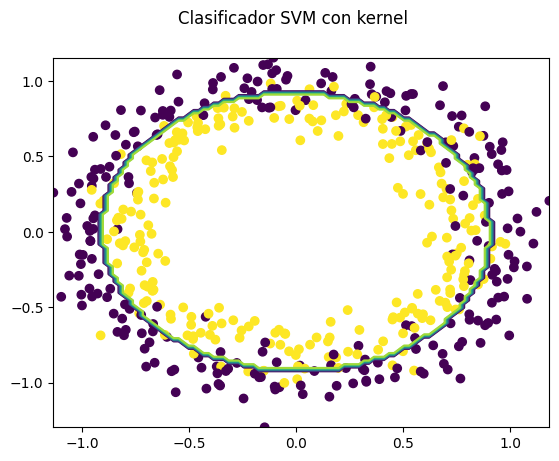

In [39]:
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_circles

x_circ, y_circ = make_circles(n_samples=500, noise=0.1,
                              random_state=1)

# Mínimos y máximos de las coordenadas en x y y de los puntos
xmin, ymin = np.min(x_circ,axis=0)
xmax, ymax = np.max(x_circ,axis=0)

n = 100
x1_grid, x2_grid = np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n))
x_grid = np.array([x1_grid, x2_grid]).reshape(2, -1).T

# --- Entrenamos el módelo en el conjunto de entrenamiento
# ------ prueba con otros kernels 
modelo = SVC(kernel='poly',degree=2)  
modelo.fit(x_circ,y_circ)       

# --- métricas de rendimiento en el conjunto de entrenamiento ---
y_pred_circ = modelo.predict(x_circ)
print(f"Accuracy: {accuracy_score(y_circ,y_pred_circ)}")
print(f"Precision: {precision_score(y_circ,y_pred_circ)}")
print(f"Recall: {recall_score(y_circ,y_pred_circ)}")

# --- generamos las predicciones para la malla
y_grid_svm = modelo.predict(x_grid)

plt.figure()
plt.suptitle("Clasificador SVM con kernel")
#-----Dibujar los datos---------------------------------
plt.scatter(x_circ[:, 0], x_circ[:, 1], c=y_circ)
#-----Dibujar X_test (la malla de fondo para ver las regiones ------------
plt.contour(x1_grid, x2_grid, y_grid_svm.reshape(100, 100))
plt.show()

#⭕ Práctica 2

Usaremos el dataset de vinos, el objetivo es determinar el origen de un vino a partir de sus caracteristicas químicas. [Más infomración](https://archive.ics.uci.edu/ml/datasets/wine). 

Los atributos son:

0. Class
1. Alcohol
2. Malic acid
3. Ash
4. Alcalinity of ash  
5. Magnesium
6. Total phenols
7. Flavanoids
8. Nonflavanoid phenols
9. Proanthocyanins
10. Color intensity
11. Hue
12. OD280/OD315 of diluted wines
13. Proline   

La práctica consiste en entrenar un clasificador lineal con kernel (SVM) para lograr el mejor posible accuracy. Puedes usar gridsearch y preprocesamiento. Reporta las 4 métricas de rendimiento, junto con la matriz de confusión.

Al usar las métricas de rendimiento, revisa la documentación. La clasificiación multiclase requiere parámetros adicionales.



In [ ]:
!apt-get -qq install > /dev/null subversion

!svn checkout "https://github.com/DCDPUAEM/DCDP/trunk/02-Machine-Learning/data/"

A    data/advertising.csv
A    data/cars-prices.csv
A    data/clasificador_lineal.py
A    data/creditcard.zip
A    data/crx.csv
A    data/fishes.csv
A    data/wine.csv
Checked out revision 186.


In [ ]:
import pandas as pd

df = pd.read_csv('/content/data/wine.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


# ⏸ Visualizar el entrenamiento (opcional)

En esta sección se muestra como graficar el proceso del entrenamiento.

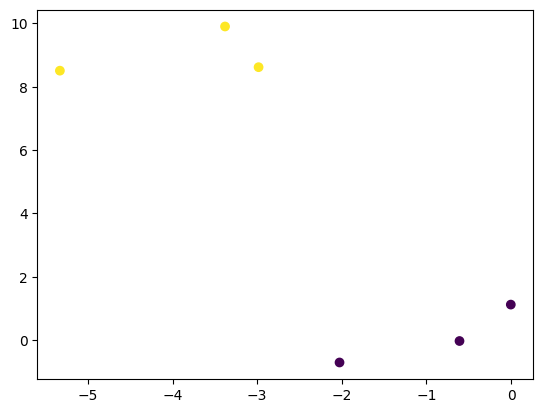

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0}

In [ ]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples=6,random_state=945,centers=2)

plt.figure()
plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

features = PolynomialFeatures(1)
X = features.fit_transform(x)

clf = Perceptron(epocas=10,eta=5)
clf.fit(X, y)
Ws = clf.W_history
y_pred = clf.predict(X)
clf.metricas(X,y)

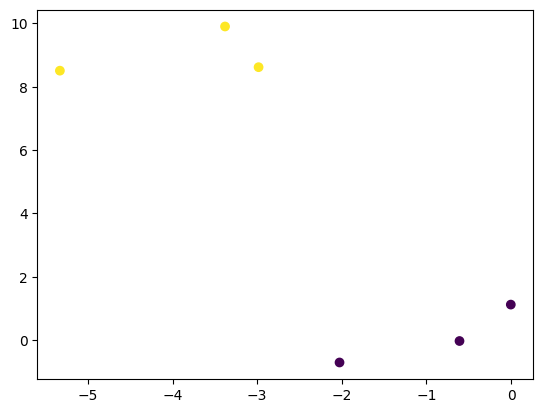

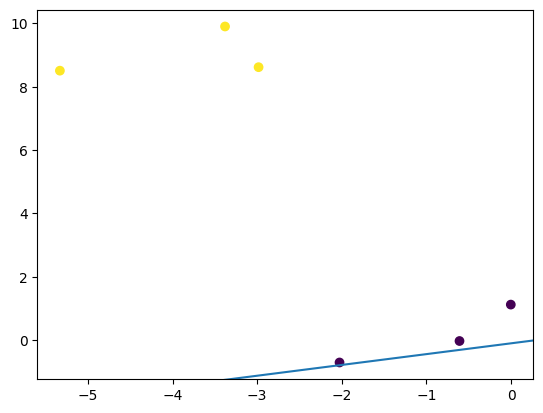

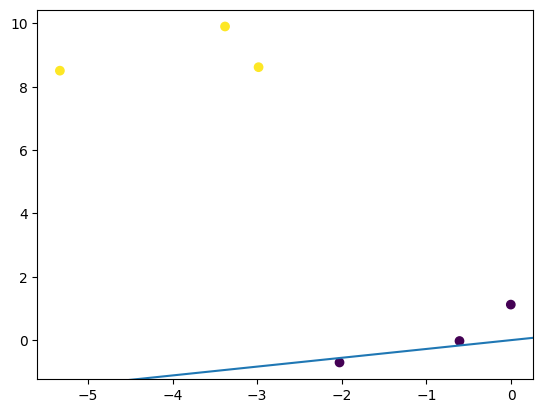

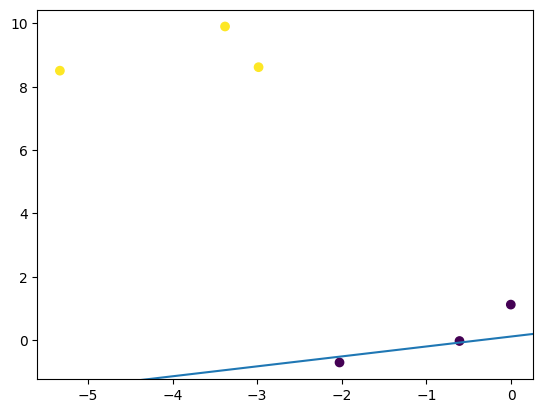

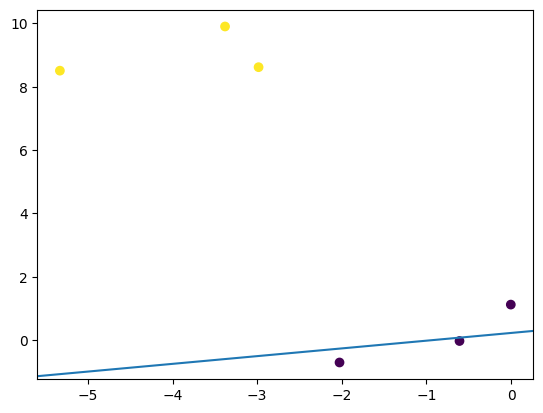

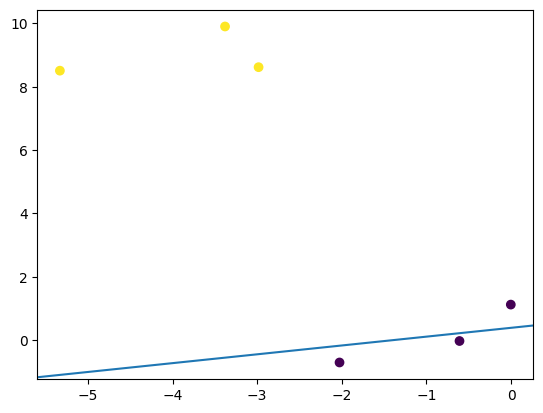

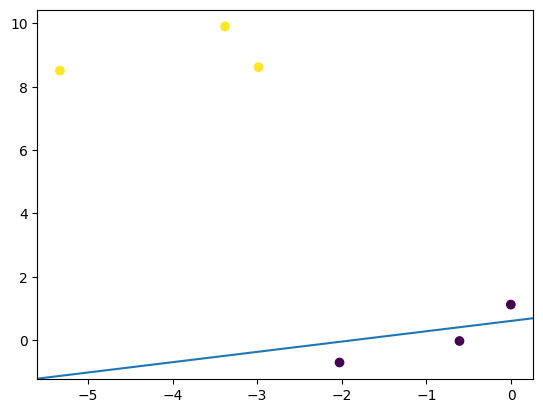

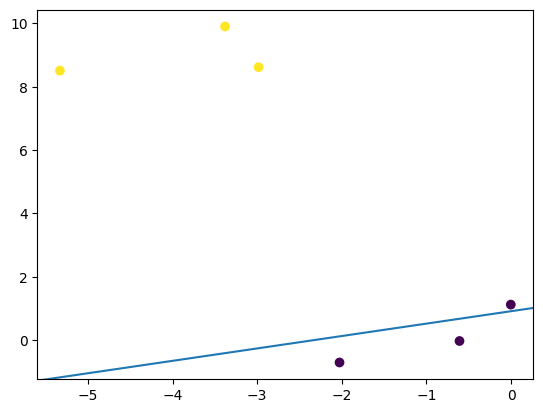

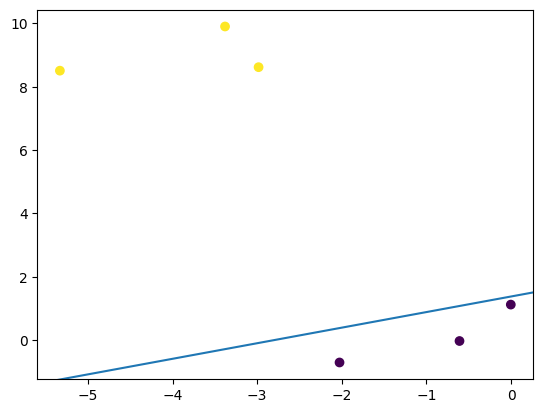

In [ ]:
xmin = np.min(x[:,0])
xmax = np.max(x[:,0])
xs = np.linspace(xmin-0.5,xmax+0.5,num=100)

def f(x,w):
    return (-w[0] - w[1]*x) / w[2]

for j,w in enumerate(Ws):
    fig = plt.figure()
    ax = fig.subplots()
    ax.scatter(x[:,0],x[:,1],c=y)
    if np.linalg.norm(w)!=0:
        xlims = ax.get_xlim()
        ylims = ax.get_ylim()
        ax.plot(xs,[f(x,w) for x in xs])
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
    if j<10:
        fig.savefig(f"perceptron-ex-0{j}.png")
    else:
        fig.savefig(f"perceptron-ex-{j}.png")
    fig.show()    